# PCA and Dimensionality Reduction
In this module, we will use techniques to help us deal with the curse of dimensionality, which is the exponential incrase in the number of combinations for a linear increase in the number of dimensions.

### Libraries and Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Importing Dataset

In [9]:
from sqlalchemy import create_engine

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

In [10]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                      postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

In [11]:
edu_df = pd.read_sql_query('select * from useducation',con=engine)

In [12]:
engine.dispose()

## Data Processing

We will begin by filling in the missing values in our dataset with data interpolation:

In [46]:
fill_list = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE",
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE",
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G",
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G",
             "GRADES_9_12_G", "GRADES_ALL_G"]

states = edu_df["STATE"].unique()

for state in states:
    edu_df.loc[edu_df["STATE"] == state, fill_list] = edu_df.loc[edu_df["STATE"] == state, fill_list].interpolate()

edu_df.dropna(inplace=True)

## 1. New Score Variables from Weighted Averages

We will create a new score variable from the weighted averages of all the score variables in the datasets:

In [60]:
fourth_grade = edu_df["GRADES_4_G"]*((edu_df["AVG_MATH_4_SCORE"] + edu_df["AVG_READING_4_SCORE"])*0.5)
eighth_grade = edu_df["GRADES_8_G"] * ((edu_df["AVG_MATH_8_SCORE"] + edu_df["AVG_READING_8_SCORE"])*0.5)
edu_df["OVERALL_SCORE"] = (fourth_grade + eigth_grade) / (edu_df["GRADES_4_G"] + edu_df["GRADES_8_G"])

## 2. Correlations between New Score Variable and Expenditure

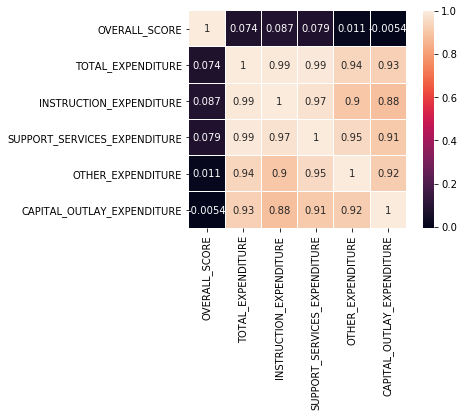

In [61]:
expenditure_types = ["TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]
sns.heatmap(edu_df[["OVERALL_SCORE"] + expenditure_types].corr(), annot=True, square=True, linewidths=.1)
plt.show()

According to our correlation table, our most correlated variable in relation to overall score is the instruction expenditure, followed by support services expenditure and thirdly total expenditure.

## 3. Apply PCA to the four expenditure typs

In [63]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = edu_df[["INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]]
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=1)
edu_df["PCA 1"] = pca.fit_transform(X)

print('The percentage of total variance from each component (PCA):\n', pca.explained_variance_ratio_)

The percentage of total variance from each component (PCA):
 [0.9430175]


The first principal component is explained by more than 94% of the total variance.

## 4. Correlation between Overall Score and first Principal Component

In [65]:
edu_df[["OVERALL_SCORE", "PCA 1", "INSTRUCTION_EXPENDITURE"]].corr()

,OVERALL_SCORE,PCA 1,INSTRUCTION_EXPENDITURE
OVERALL_SCORE,1.000000,0.044596,0.087386
PCA 1,0.044596,1.000000,0.968606
INSTRUCTION_EXPENDITURE,0.087386,0.968606,1.000000


## 5. Choosing best variables

Examining our expenditure variables, we see that they are more correlated with overall score than with the first principal component. We should use the expenditure variables instead of our PCA. We would prefer our PCA variables when the correlation between the variables are lesss than or equal to 0.8 as is standard. Our expenditure variables are all very correlated with each other (All correlations are above 0.8